In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tidegauge_functions import read_tidegauge_psmsl
from tidegauge_functions import find_skiprows_startofline
from tidegauge_functions import read_tidegauge_monthly

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
path = os.walk("data/tidegauge")
totalLoops = 0 

for root, directories, files in path:
    for directory in directories:
        print(directory)
    for file in files:
        tideName = files           #Fills the indices of the array with file names.
        totalLoops = totalLoops + 1 #Counts how many iterations the for loop completed.
        tideArray = files             #Creates the amount of indices needed for this array.

.ipynb_checkpoints


In [3]:
dir_in = 'data/tidegauge'

i = 1
while i < totalLoops:   
    file_in = tideArray[i]
    filepath = os.path.join(dir_in, file_in)
    tideArray[i] = read_tidegauge_psmsl(filepath)
    i = i + 1

In [4]:
spadaDf = read_tidegauge_monthly('data/tidegauge/915.csv')

In [5]:
tideArray[6]['SSH'] = tideArray[6]['SSH'] - tideArray[6]['SSH'].mean()

In [6]:
tideArray[6] = tideArray[6].resample('M').mean()

In [7]:
combinedNuuk = spadaDf
combinedNuuk = spadaDf.append(tideArray[6])

In [8]:
def para(df):
    paraDf = df['SSH'].resample('MS').mean()

    # The term bfill means that we use the value before filling in missing values
    paraDf = paraDf.fillna(paraDf.bfill())
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(paraDf,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    

In [9]:
def arima(df, totalSteps, param, param_seasonal):  
    
    #The 'MS' string groups the data in buckets by start of the month
    arimaDf = df['SSH'].resample('MS').mean()

    #The term bfill means that we use the value before filling in missing values
    arimaDf = arimaDf.fillna(arimaDf.bfill())

    mod = sm.tsa.statespace.SARIMAX(arimaDf,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)                      
    results = mod.fit()

    # Get forecast 500 steps ahead in future
    pred_uc = results.get_forecast(steps= totalSteps)

    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    
    ax = arimaDf.plot(label='observed', figsize=(20, 15))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('SSH')

    plt.legend()
    plt.show()
    
    return

In [ ]:
#Churchill combinations of (p, d, q) and (P, D, Q, S) seasonal component.
para(tideArray[1])

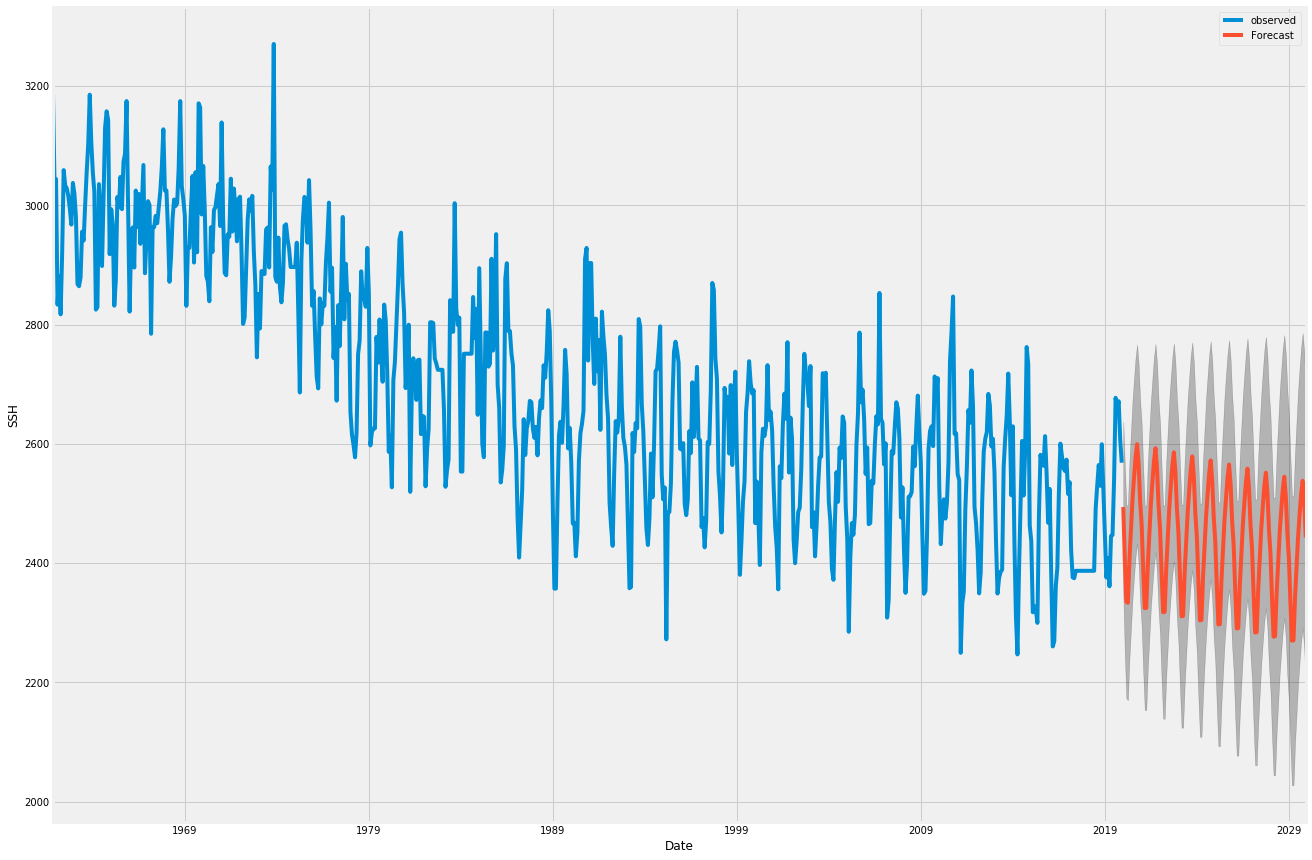

In [10]:
#Churchill forecast.
arima(tideArray[1], 120, (1, 1, 1), (0, 1, 1, 12))

In [ ]:
#Thule combinations of (p, d, q) and (P, D, Q, S) seasonal component.
para(tideArray[4])

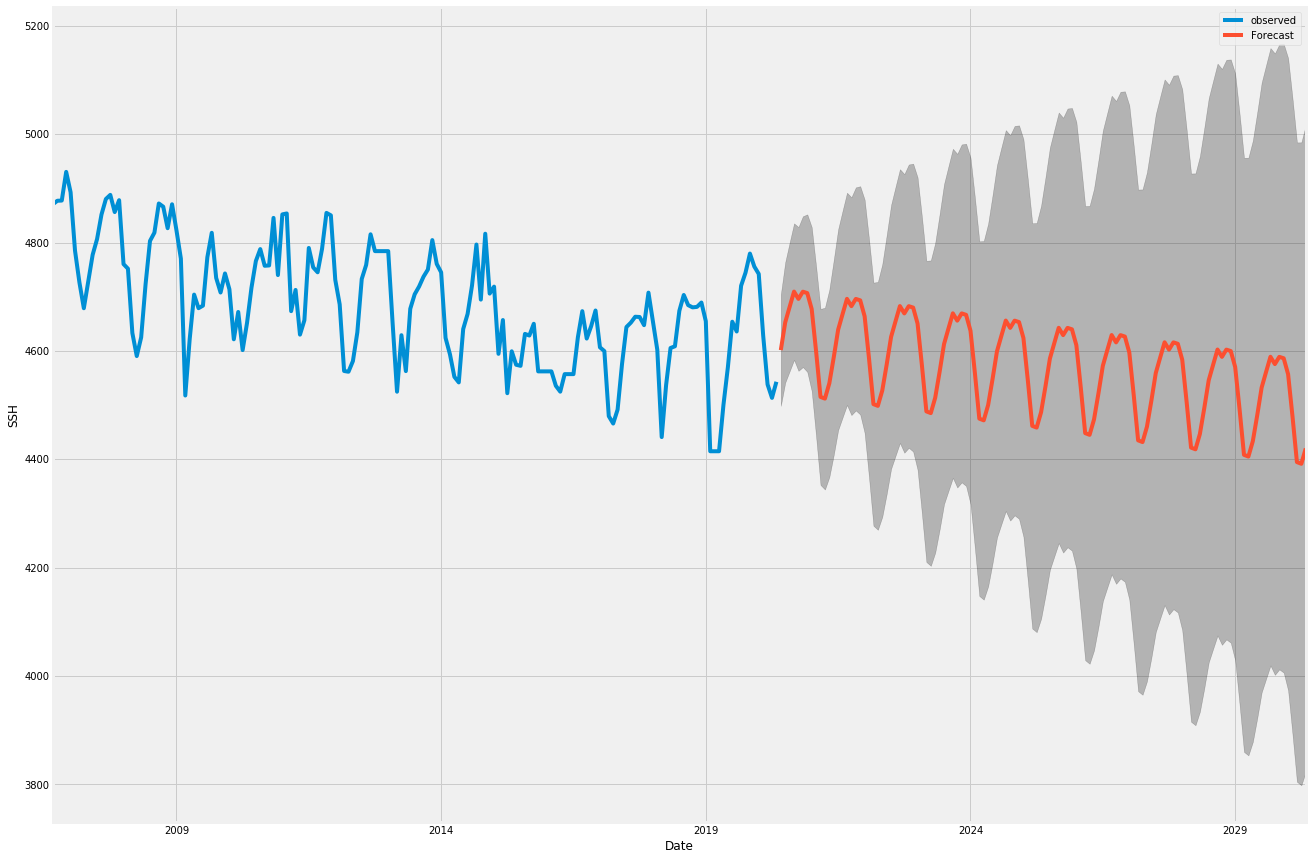

In [11]:
#Thule
arima(tideArray[4], 120, (0, 1, 1), (0, 1, 1, 12))

In [ ]:
#Nuuk(Spada) combinations of (p, d, q) and (P, D, Q, S) seasonal component.
para(spadaDf)

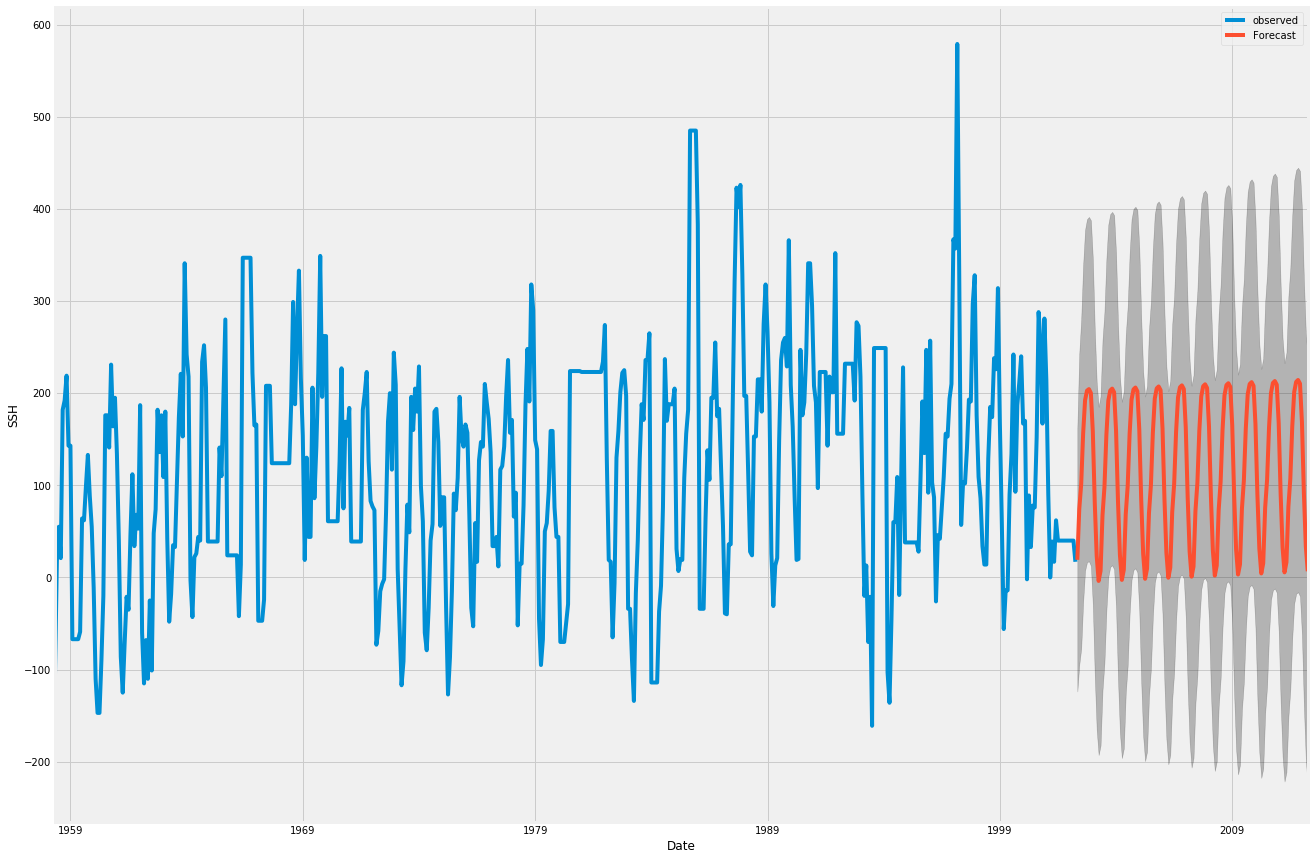

In [12]:
#Nuuk(Spada) forecast.
arima(spadaDf, 120, (1, 1, 1), (0, 1, 1, 12))

In [ ]:
#Nuuk(combined) combinations of (p, d, q) and (P, D, Q, S) seasonal component.
para(combinedNuuk)

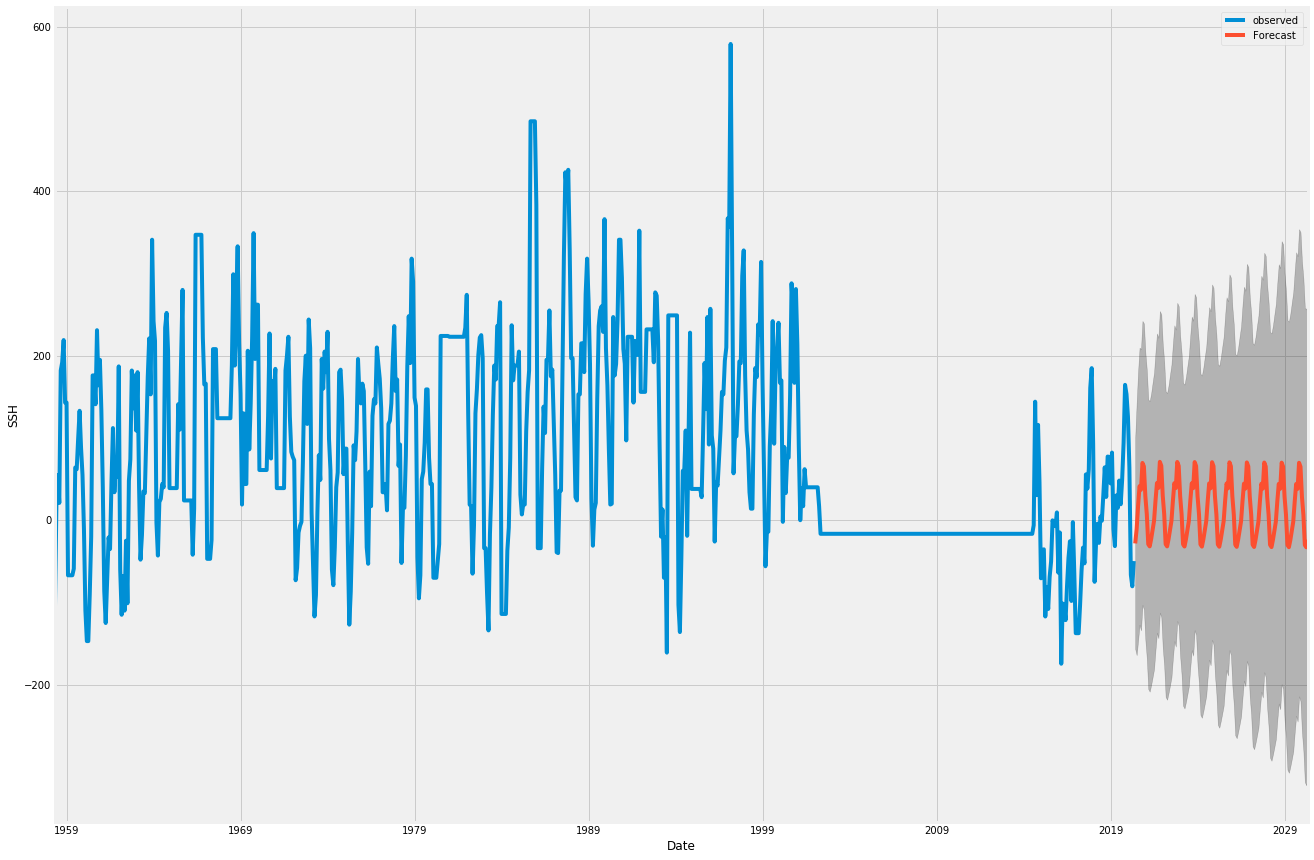

In [13]:
#Nuuk(combined) forecast.
arima(combinedNuuk, 120, (1, 1, 1), (0, 1, 1, 12))